# This notebook illustrates the choice of tuning parameter $\lambda$ in ridge regression by EFCP, VFCP and cross-validation using two or three splits in both linear and non-linear setting.

## Linear setting

In [21]:
library(repr)
library(glmnet)
library(MASS)
library(mvtnorm)
source("ridge_funs.R")
name=paste("linear_fm_t3",sep="")
set.seed(2021)

df <- 3  #degrees of freedom
l <- 1    #number of dimensions 
l.lambda <- 100
lambda_seq <- seq(0,200,l=l.lambda)
dim <- 5
alpha <- 0.1
n <- 200   #number of training samples
n0 <- 100  #number of prediction points
nrep <- 100 #number of independent trials
rho <- 0.5

cov.efcp <- len.efcp <- matrix(0,nrep,l)
cov.vfcp <- len.vfcp <- matrix(0,nrep,l)
cov.naive <- len.naive <- matrix(0,nrep,l)
cov.param <- len.param <- matrix(0,nrep,l)
cov.star <- len.star <- matrix(0,nrep,l)
cov.cv10 <- len.cv10 <- matrix(0,nrep,l)
cov.cv5 <- len.cv5 <- matrix(0,nrep,l)
cov.cvloo <- len.cvloo <- matrix(0,nrep,l)


out.efcp.up <- out.efcp.lo <- matrix(0,n0,l)
out.vfcp.up <- out.vfcp.lo <- matrix(0,n0,l)
out.naive.up <- out.naive.lo <- matrix(0,n0,l)
out.param.up <- out.param.lo <- matrix(0,n0,l)
out.star.up <- out.star.lo <- matrix(0,n0,l)
out.cv10.up <- out.cv10.lo <- matrix(0,n0,l)
out.cv5.up <- out.cv5.lo <- matrix(0,n0,l)
out.cvloo.up <- out.cvloo.lo <- matrix(0,n0,l)

lambda.efcp <- lambda.vfcp <- lambda.star <- lambda.cv5 <- rep(0,nrep)


for(i in 1:nrep){
  for (r in 1:l){
    d <- dim[r]
    set.seed(i)
    
    Sigma <- matrix(rho,d,d)
    diag(Sigma) <- rep(1,d)
    X <- rmvt(n,Sigma,df)	#multivariate t distribution
    beta <- rep(1:5,d/5)
    eps <- rt(n,df)*(1+sqrt(X[,1]^2+X[,2]^2))
    Y <- X%*%beta+eps
    
    
    X0 <- rmvt(n0,Sigma,df)
    eps0 <- rt(n0,df)*(1+sqrt(X0[,1]^2+X0[,2]^2))
    Y0 <- X0%*%beta+eps0
    
    
    out.param <- ginverse.fun(X,Y,X0,alpha=alpha)
    out.param.lo[,r] <- out.param$lo
    out.param.up[,r] <- out.param$up    
    cov.param[i,r] <- mean(out.param.lo[,r] <= Y0 & Y0 <= out.param.up[,r]) 
    len.param[i,r] <- mean(out.param.up[,r]-out.param.lo[,r])  
    
    out.efcp <- efcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.efcp.up[,r] <- out.efcp$up
    out.efcp.lo[,r] <- out.efcp$lo    
    cov.efcp[i,r] <- mean(out.efcp.lo[,r] <= Y0 & Y0 <= out.efcp.up[,r]) 
    len.efcp[i,r] <- mean(out.efcp.up[,r]-out.efcp.lo[,r]) 
    lambda.efcp[i] <- out.efcp$lambda
    
    out.vfcp <- vfcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.vfcp.up[,r] <- out.vfcp$up
    out.vfcp.lo[,r] <- out.vfcp$lo    
    cov.vfcp[i,r] <- mean(out.vfcp.lo[,r] <= Y0 & Y0 <= out.vfcp.up[,r]) 
    len.vfcp[i,r] <- mean(out.vfcp.up[,r]-out.vfcp.lo[,r]) 
    lambda.vfcp[i] <- out.vfcp$lambda
      
    out.naive <- naive.fun(X,Y,X0,alpha=alpha)
    out.naive.up[,r] <- out.naive$up
    out.naive.lo[,r] <- out.naive$lo    
    cov.naive[i,r] <- mean(out.naive.lo[,r] <= Y0 & Y0 <= out.naive.up[,r]) 
    len.naive[i,r] <- mean(out.naive.up[,r]-out.naive.lo[,r]) 
    
    out.star <- star.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.star.up[,r] <- out.star$up
    out.star.lo[,r] <- out.star$lo   
    cov.star[i,r] <- mean(out.star.lo[,r] <= Y0 & Y0 <= out.star.up[,r]) 
    len.star[i,r] <- mean(out.star.up[,r] - out.star.lo[,r]) 
    lambda.star[i] <- out.star$lambda
    
    out.cv5 <- cv.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha,nfolds=5)
    out.cv5.up[,r] <- out.cv5$up
    out.cv5.lo[,r] <- out.cv5$lo    
    cov.cv5[i,r] <- mean(out.cv5.lo[,r] <= Y0 & Y0 <= out.cv5.up[,r]) 
    len.cv5[i,r] <- mean(out.cv5.up[,r] - out.cv5.lo[,r])
    lambda.cv5[i] <- out.cv5$lambda
  }
}

df.cov <- data.frame(dim,apply(cov.param,2,mean),apply(cov.naive,2,mean),apply(cov.vfcp,2,mean),apply(cov.star,2,mean),apply(cov.cv5,2,mean), apply(cov.efcp,2,mean))

df.len <- data.frame(dim,apply(len.param,2,mean),apply(len.naive,2,mean),apply(len.vfcp,2,mean),apply(len.star,2,mean),apply(len.cv5,2,mean), apply(len.efcp,2,mean))



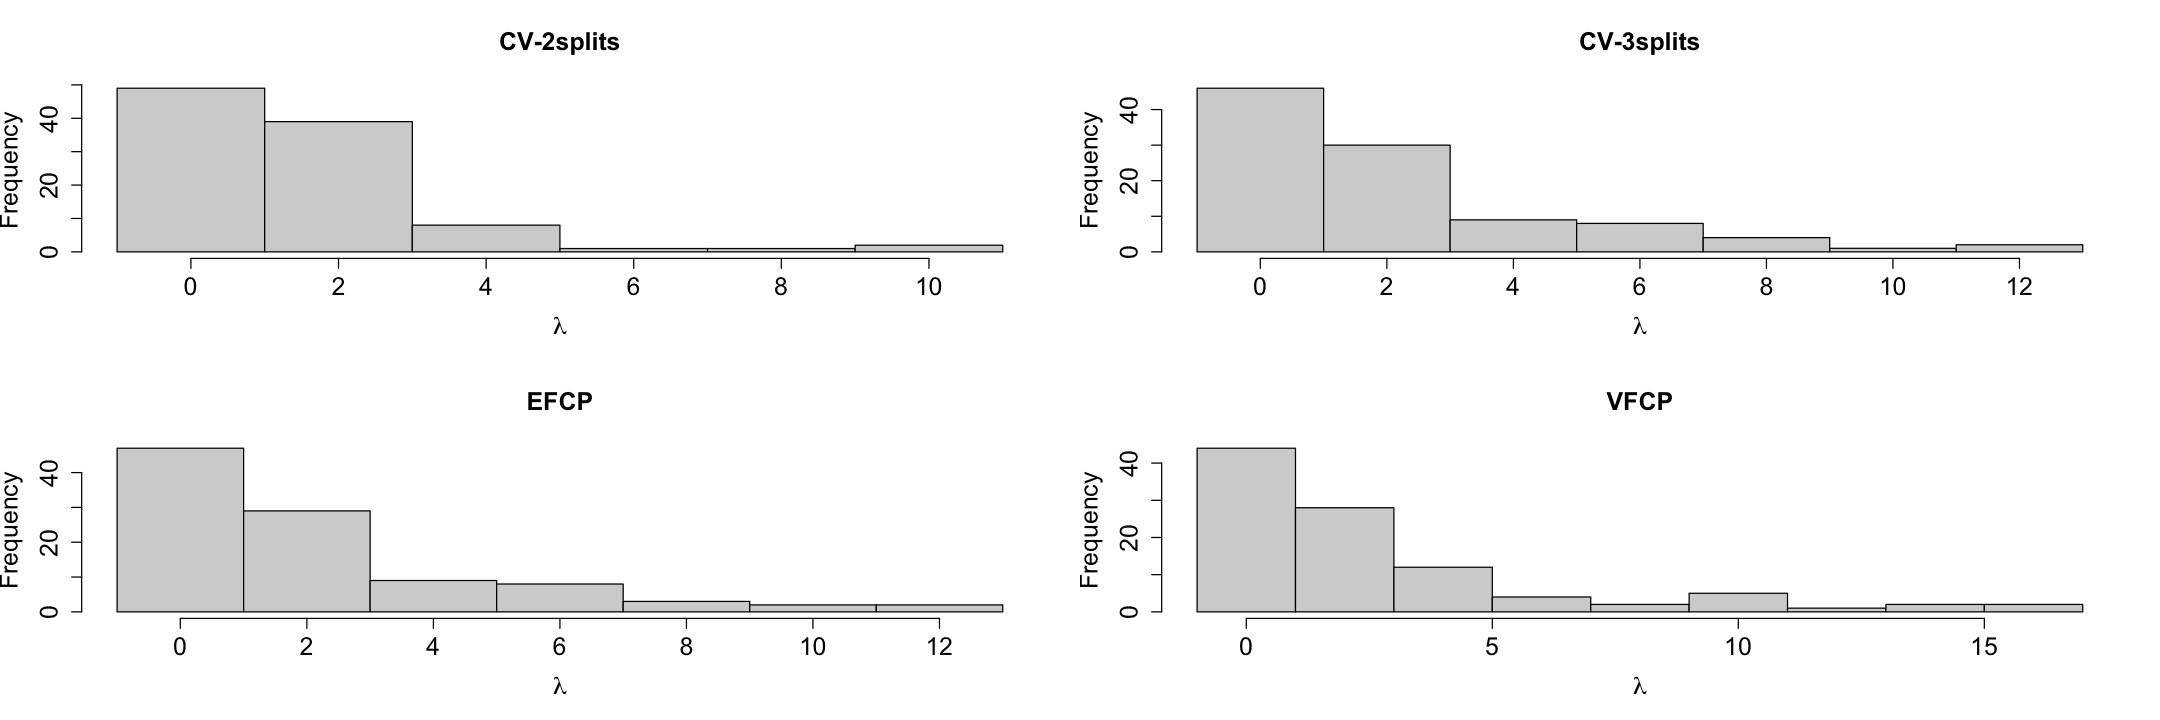

In [58]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(2,2))
hist(lambda.cv5,breaks=seq(min(lambda.cv5)-1,max(lambda.cv5)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="CV-2splits") #make x,y, values, main larger
hist(lambda.star,breaks=seq(min(lambda.star)-1,max(lambda.star)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="CV-3splits")
hist(lambda.efcp,breaks=seq(min(lambda.efcp)-1,max(lambda.efcp)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="EFCP")
hist(lambda.vfcp,breaks=seq(min(lambda.vfcp)-1,max(lambda.vfcp)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="VFCP")

The above plots show that all four methods mostly use $\lambda$ close to zero, which is expected given that the underlying data generating mechanism is a linear setting.

## Nonlinear setting

In [59]:
name=paste("nonlinear_fm_t3",sep="")
set.seed(2021)

df <- 3  #degrees of freedom
l <- 1    #number of dimensions 
l.lambda <- 100
lambda_seq <- seq(0,200,l=l.lambda)
dim <- 5
alpha <- 0.1
n <- 200   #number of training samples
n0 <- 100  #number of prediction points
nrep <- 100 #number of independent trials
rho <- 0.5

cov.efcp <- len.efcp <- matrix(0,nrep,l)
cov.vfcp <- len.vfcp <- matrix(0,nrep,l)
cov.naive <- len.naive <- matrix(0,nrep,l)
cov.param <- len.param <- matrix(0,nrep,l)
cov.star <- len.star <- matrix(0,nrep,l)
cov.cv10 <- len.cv10 <- matrix(0,nrep,l)
cov.cv5 <- len.cv5 <- matrix(0,nrep,l)
cov.cvloo <- len.cvloo <- matrix(0,nrep,l)


out.efcp.up <- out.efcp.lo <- matrix(0,n0,l)
out.vfcp.up <- out.vfcp.lo <- matrix(0,n0,l)
out.naive.up <- out.naive.lo <- matrix(0,n0,l)
out.param.up <- out.param.lo <- matrix(0,n0,l)
out.star.up <- out.star.lo <- matrix(0,n0,l)
out.cv10.up <- out.cv10.lo <- matrix(0,n0,l)
out.cv5.up <- out.cv5.lo <- matrix(0,n0,l)
out.cvloo.up <- out.cvloo.lo <- matrix(0,n0,l)

lambda.efcp <- lambda.vfcp <- lambda.star <- lambda.cv5 <- rep(0,nrep)


for(i in 1:nrep){
  for (r in 1:l){
    d <- dim[r]
    set.seed(i)
    
    Sigma=matrix(rho,d,d)
    diag(Sigma)=rep(1,d)
    X=rmvt(n,Sigma,df)	#multivariate t distribution

    eps1=rt(n,df)*(1+sqrt(X[,1]^2+X[,2]^2))
    eps2=rt(n,df)*(1+sqrt(X[,1]^4+X[,2]^4))
    Y=rpois(n,sin(X[,1])^2 + cos(X[,2])^4+0.01 )+0.03*X[,1]*eps1+25*(runif(n,0,1)<0.01*eps2)

    X0=rmvt(n0,Sigma,df)
    eps01=rt(n0,df)*(1+sqrt(X0[,1]^2+X0[,2]^2))
    eps02=rt(n0,df)*(1+sqrt(X0[,1]^4+X0[,2]^4))
    Y0=rpois(n0,sin(X0[,1])^2 + cos(X0[,2])^4+0.01 )+0.03*X0[,1]*eps01+25*(runif(n0,0,1)<0.01)*eps02
    
    
    out.param <- ginverse.fun(X,Y,X0,alpha=alpha)
    out.param.lo[,r] <- out.param$lo
    out.param.up[,r] <- out.param$up    
    cov.param[i,r] <- mean(out.param.lo[,r] <= Y0 & Y0 <= out.param.up[,r]) 
    len.param[i,r] <- mean(out.param.up[,r]-out.param.lo[,r])  
    
    out.efcp <- efcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.efcp.up[,r] <- out.efcp$up
    out.efcp.lo[,r] <- out.efcp$lo    
    cov.efcp[i,r] <- mean(out.efcp.lo[,r] <= Y0 & Y0 <= out.efcp.up[,r]) 
    len.efcp[i,r] <- mean(out.efcp.up[,r]-out.efcp.lo[,r]) 
    lambda.efcp[i] <- out.efcp$lambda
    
    out.vfcp <- vfcp_ridge(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.vfcp.up[,r] <- out.vfcp$up
    out.vfcp.lo[,r] <- out.vfcp$lo    
    cov.vfcp[i,r] <- mean(out.vfcp.lo[,r] <= Y0 & Y0 <= out.vfcp.up[,r]) 
    len.vfcp[i,r] <- mean(out.vfcp.up[,r]-out.vfcp.lo[,r]) 
    lambda.vfcp[i] <- out.vfcp$lambda
      
    out.naive <- naive.fun(X,Y,X0,alpha=alpha)
    out.naive.up[,r] <- out.naive$up
    out.naive.lo[,r] <- out.naive$lo    
    cov.naive[i,r] <- mean(out.naive.lo[,r] <= Y0 & Y0 <= out.naive.up[,r]) 
    len.naive[i,r] <- mean(out.naive.up[,r]-out.naive.lo[,r]) 
    
    out.star <- star.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha)
    out.star.up[,r] <- out.star$up
    out.star.lo[,r] <- out.star$lo   
    cov.star[i,r] <- mean(out.star.lo[,r] <= Y0 & Y0 <= out.star.up[,r]) 
    len.star[i,r] <- mean(out.star.up[,r] - out.star.lo[,r]) 
    lambda.star[i] <- out.star$lambda
    
    out.cv5 <- cv.fun(X,Y,X0,lambda=lambda_seq,alpha=alpha,nfolds=5)
    out.cv5.up[,r] <- out.cv5$up
    out.cv5.lo[,r] <- out.cv5$lo    
    cov.cv5[i,r] <- mean(out.cv5.lo[,r] <= Y0 & Y0 <= out.cv5.up[,r]) 
    len.cv5[i,r] <- mean(out.cv5.up[,r] - out.cv5.lo[,r])
    lambda.cv5[i] <- out.cv5$lambda
  }
}


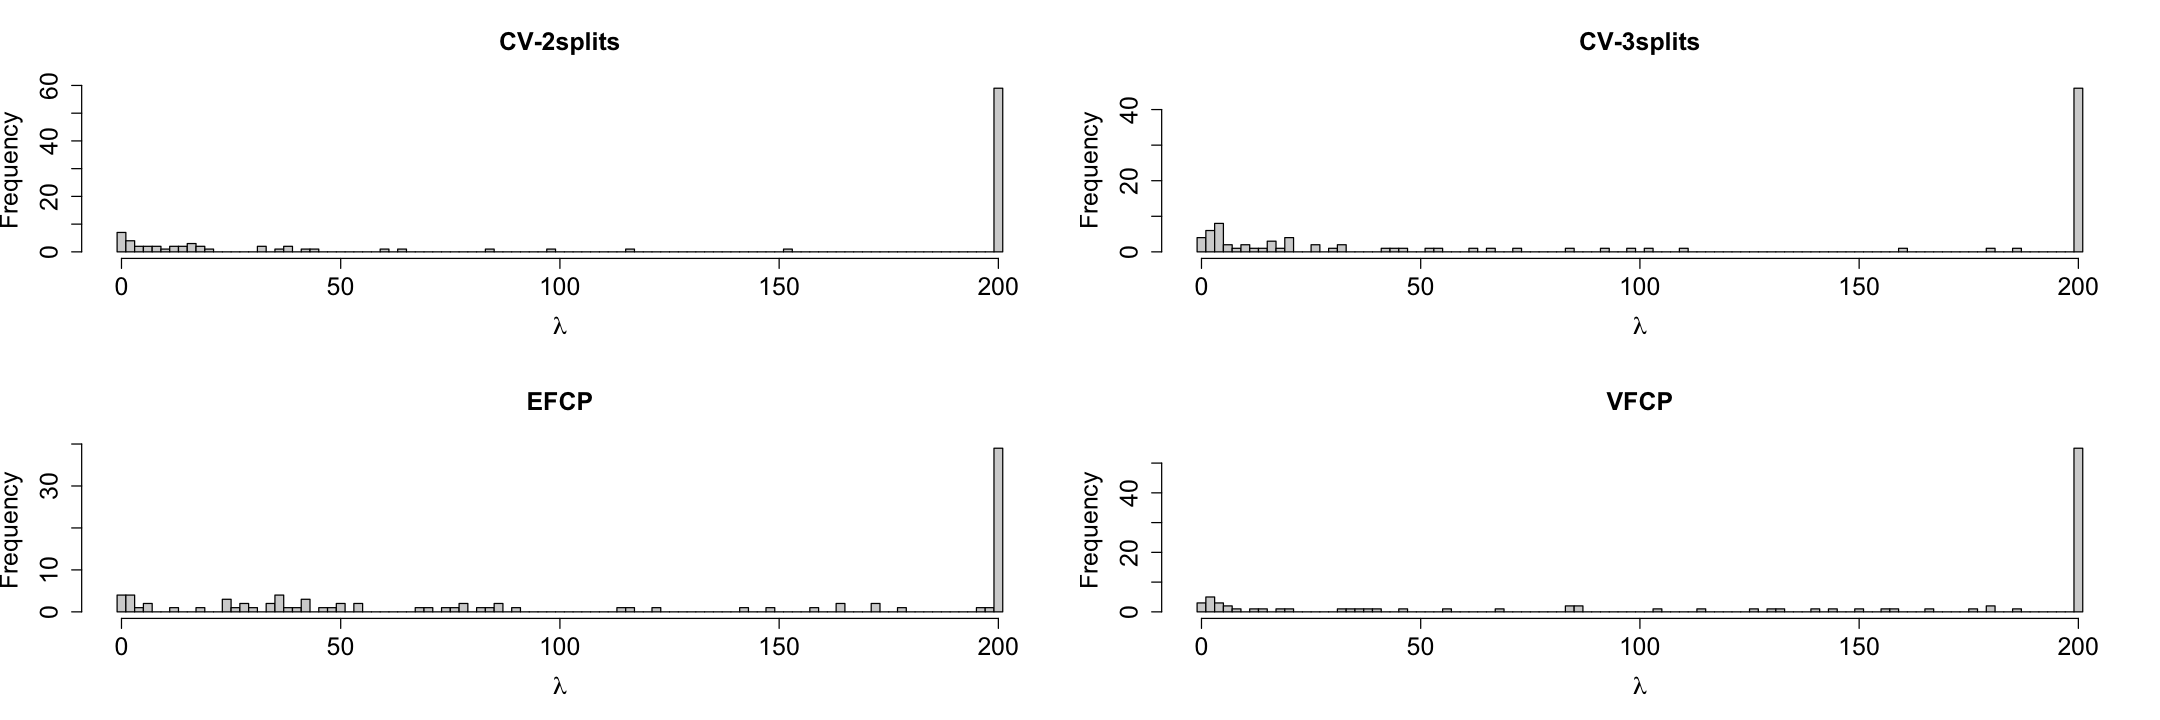

In [60]:
options(repr.plot.width=18, repr.plot.height=6)
par(mfrow=c(2,2))
hist(lambda.cv5,breaks=seq(min(lambda.cv5)-1,max(lambda.cv5)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="CV-2splits") #make x,y, values, main larger
hist(lambda.star,breaks=seq(min(lambda.star)-1,max(lambda.star)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="CV-3splits")
hist(lambda.efcp,breaks=seq(min(lambda.efcp)-1,max(lambda.efcp)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="EFCP")
hist(lambda.vfcp,breaks=seq(min(lambda.vfcp)-1,max(lambda.vfcp)+1, by = 2),xlab=expression(lambda), cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5,main="VFCP")

The above plots show that all four methods mostly choose the penalty parameter $\lambda$ to be as large as possible, which is also expected given that the underlying data generating mechanism is a nonlinear setting.